ARIMA Model – Time Series Forecasting

Using ARIMA model (AutoRegressive Integrated Moving Average), you can forecast a time series using the series past values (examining a past value's own lags and the lagged forecast errors). Specifically, ‘Auto Regressive’ means ARIMA is a linear regression model that uses its own lags as predictors. In this post, we build an optimal ARIMA model from scratch and extend it to Seasonal ARIMA (SARIMA) and SARIMAX models.

Source: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

Here, Univariate Time Series Forecasting was employed because we used only the previous values of the time series to predict its future values.

ARIMA model is characterized by 3 terms: p, d, q

p = Order of the ‘Auto Regressive’ (AR) term which refers to the number of lags of Y to be used as predictors. 

q = Order of the ‘Moving Average’ (MA) term which refers to the number of lagged forecast errors that should go into the ARIMA Model.

d = Number of differencing required to make the time series stationary. To make a series stationary, we difference it or subtract the previous value from the current value. The value of d, therefore, is the minimum number of differencing needed to make the series stationary (if the time series is already stationary, then d = 0).

NOTE: When using predictors other than the series (a.k.a exogenous variables) to forecast, employ Multi Variate Time Series Forecasting.

In [3]:
# Modules
import os

# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

# Use numpy to convert to arrays
import numpy as np

from scipy.stats import sem

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Import the model we are using
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

In [27]:
# STEP 1: Finding the order of differencing

from statsmodels.tsa.stattools import adfuller
from numpy import log

In [5]:
# Load the "US_emissions_by_gas_1990-2017_data.xlsx" Dataset

US_gas_data = pd.read_excel("data/US_emissions_by_gas_1990_2017_data.xlsx")
US_gas_data.head()

,Year,Carbon_dioxide,Methane,Nitrous_oxide,Fluorinated_gases,Total
0,1990,5121.179440,779.845550,370.307694,99.667859,6371.000543
1,1991,5071.563914,784.384856,368.961757,90.704668,6315.615194
2,1992,5174.670601,783.176602,371.786442,95.300712,6424.934357
3,1993,5281.386608,770.308404,385.347234,95.027350,6532.069596
4,1994,5375.033803,775.160651,376.511527,98.129806,6624.835787


In [8]:
# Check if the Carbon_dioxide series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.
result = adfuller(US_gas_data.Carbon_dioxide.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.038130
p-value: 0.031484


RULE: The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

If,

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

So, since p-value: 0.031484, then the null hypothesis (H0) is rejected; and the data does not have a unit root and is stationary!

In [10]:
# Check if the Methane series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.
result = adfuller(US_gas_data.Methane.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.003607
p-value: 0.751947


In [11]:
# Check if the Nitrous_oxide series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.
result = adfuller(US_gas_data.Nitrous_oxide.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.010076
p-value: 0.033964


So, since p-value: 0.033964, then the null hypothesis (H0) is rejected; and the data does not have a unit root and is stationary!

In [12]:
# Check if the Fluorinated_gases series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.
result = adfuller(US_gas_data.Fluorinated_gases.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.591758
p-value: 0.872834


In [13]:
# Check if the Total series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.
result = adfuller(US_gas_data.Total.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.660969
p-value: 0.081039


Since the p-values of Methane, Fluorinated gases and Total were not less than 0.05 and greater than the significance level, differencing the series is necessary.

Below is the autocorrelation plot for Methane.

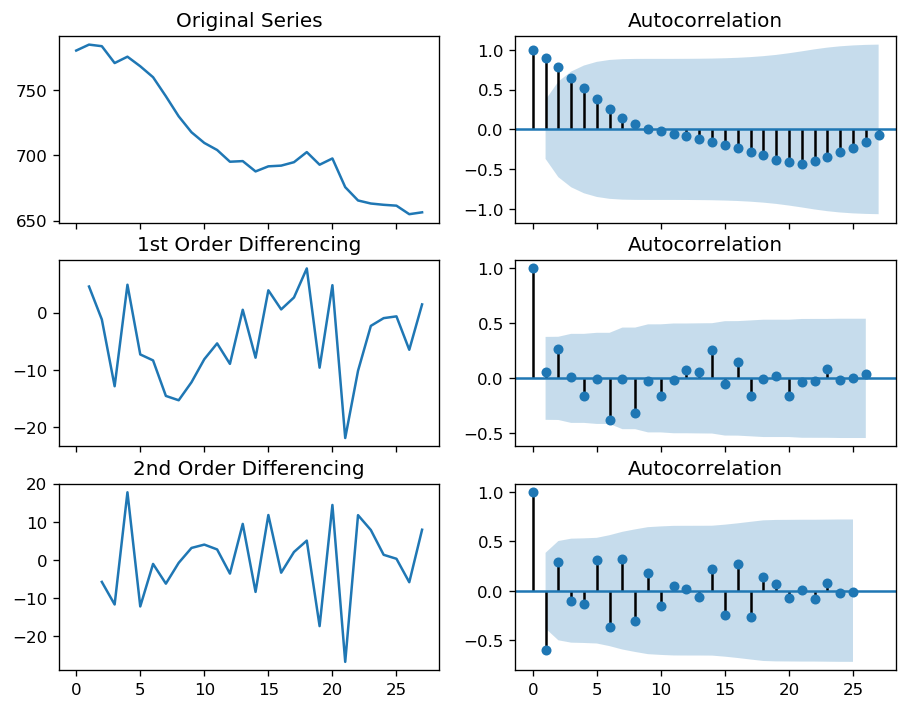

In [16]:
## Differencing Methane series.

import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(US_gas_data.Methane); axes[0, 0].set_title('Original Series')
plot_acf(US_gas_data.Methane, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(US_gas_data.Methane.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(US_gas_data.Methane.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(US_gas_data.Methane.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(US_gas_data.Methane.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [19]:
# Methane series 1st order differencing.

methane_1diff = adfuller(US_gas_data.Methane.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.692242
p-value: 0.000087


p-value of Methane is now <0.05, now stationary, at 1 order of differencing!

NOTE: In the 2nd order differencing autocorrelation plot, the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.

Below is the autocorrelation plot for Fluorinated_gases.

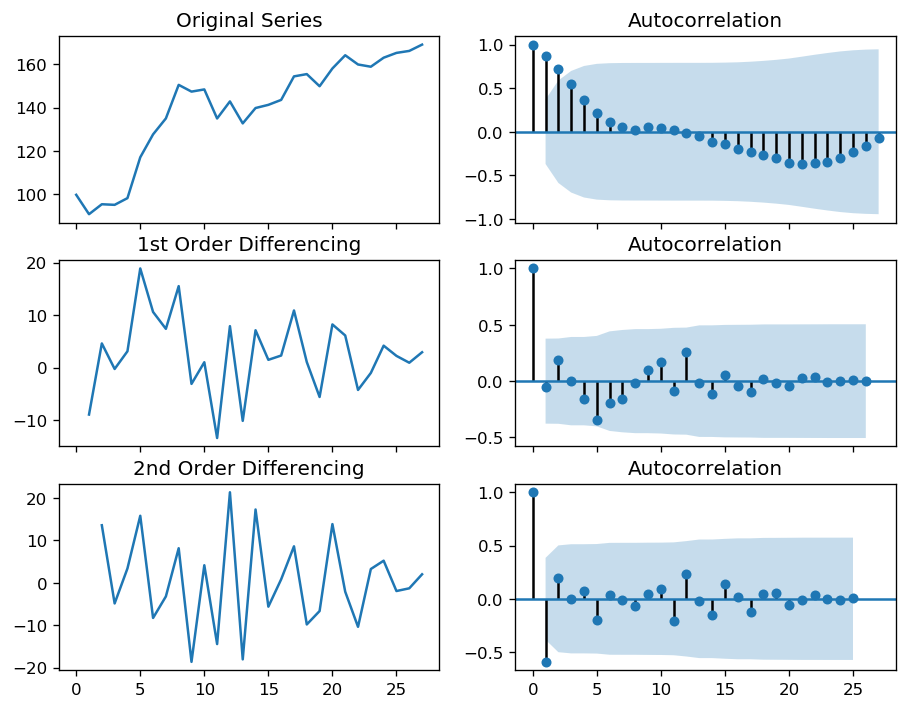

In [21]:
## Differencing Fluorinated_gases series.

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(US_gas_data.Fluorinated_gases); axes[0, 0].set_title('Original Series')
plot_acf(US_gas_data.Fluorinated_gases, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(US_gas_data.Fluorinated_gases.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(US_gas_data.Fluorinated_gases.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(US_gas_data.Fluorinated_gases.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(US_gas_data.Fluorinated_gases.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [25]:
# Fluorinated_gases series 1st order differencing.

fluorinated_1diff = adfuller(US_gas_data.Fluorinated_gases.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.692242
p-value: 0.000087


p-value of Fluorinated_gases is now <0.05, now stationary, at 1 order of differencing!

Below is the autocorrelation plot for Total.

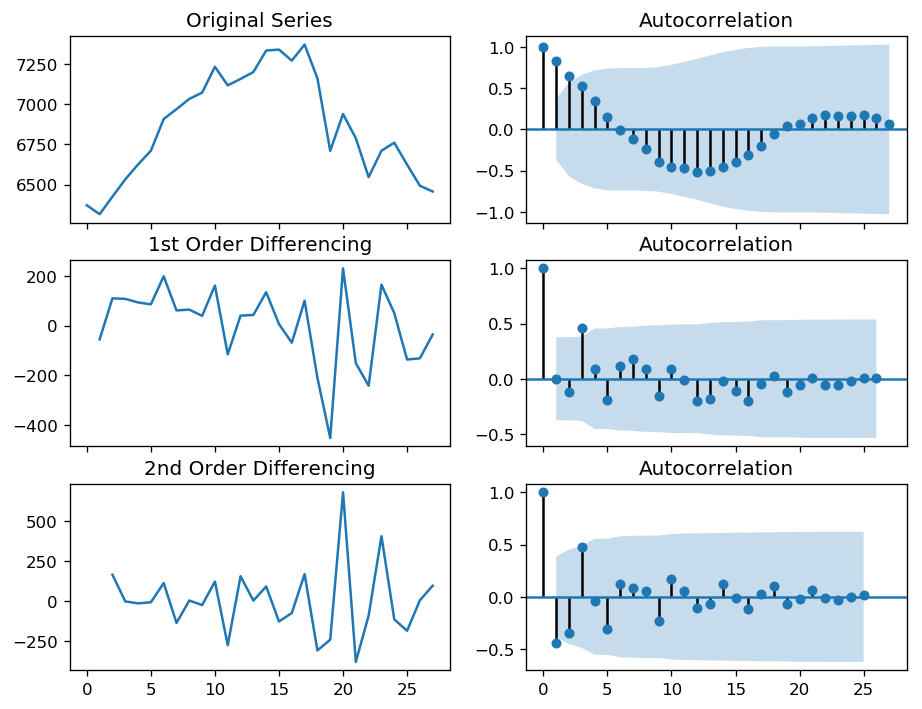

In [23]:
## Differencing Total series.

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(US_gas_data.Total); axes[0, 0].set_title('Original Series')
plot_acf(US_gas_data.Total, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(US_gas_data.Total.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(US_gas_data.Total.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(US_gas_data.Total.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(US_gas_data.Total.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [24]:
# Total series 1st order differencing.

total_1diff = adfuller(US_gas_data.Total.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.692242
p-value: 0.000087


p-value of Total is now <0.05, now stationary, at 1 order of differencing!

STEP 2: Find the order of the AR term (p). Inspect the Partial Autocorrelation (PACF), or the correlation between the series and its lag, to determine if a particular lag is needed in the AR term for pure correlation. 

In [ ]:

from pmdarima.arima.utils import ndiffs
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
y = df.value

## Adf Test
ndiffs(y, test='adf')  # 2

# KPSS test
ndiffs(y, test='kpss')  # 0

# PP test:
ndiffs(y, test='pp')  # 2

In [47]:
# Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. 
# So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(US_gas_data.Carbon_dioxide; axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(US_gas_data.Carbon_dioxide.dropna(), ax=axes[1])

plt.show()

SyntaxError: invalid syntax (<ipython-input-47-9150252ee0c0>, line 8)

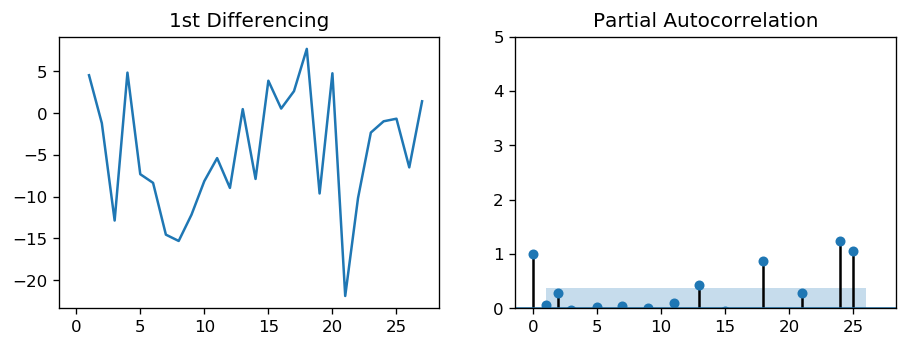

In [29]:
# PACF plot of 1st differenced Methane series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(US_gas_data.Methane.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(US_gas_data.Methane.diff().dropna(), ax=axes[1])

plt.show()

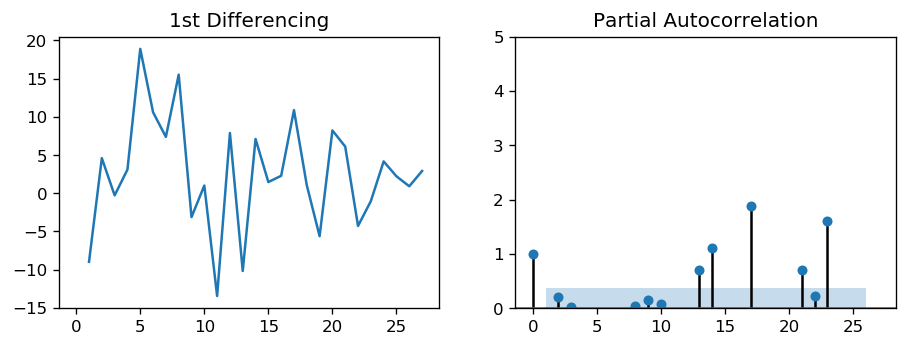

In [30]:
# PACF plot of 1st differenced Fluorinated_gases series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(US_gas_data.Fluorinated_gases.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(US_gas_data.Fluorinated_gases.diff().dropna(), ax=axes[1])

plt.show()

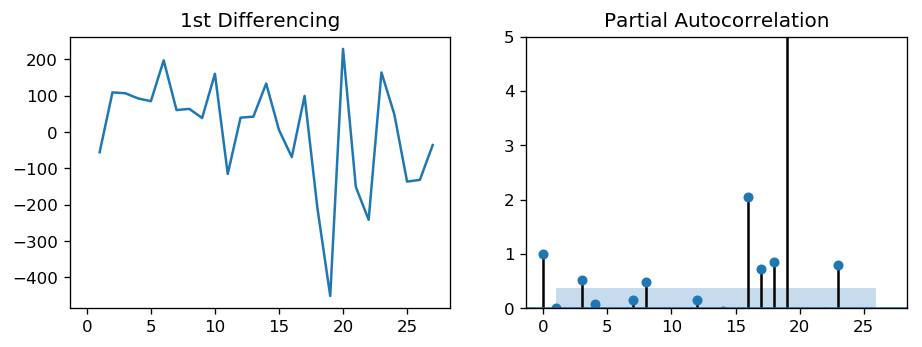

In [31]:
# PACF plot of 1st differenced Total series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(US_gas_data.Total.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(US_gas_data.Total.diff().dropna(), ax=axes[1])

plt.show()

STEP 3: Find the order of the MA term (q).

In [34]:
#import pandas as pd
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Import data
#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/austa.csv')

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(US_gas_data.Methane.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(US_gas_data.Methane.diff().dropna(), ax=axes[1])

plt.show()

SyntaxError: invalid syntax (<ipython-input-34-486a7fcf3996>, line 1)

In [43]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(US_gas_data.Carbon_dioxide, order=(1,2,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:      D2.Carbon_dioxide   No. Observations:                   26
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -172.023
Method:                       css-mle   S.D. of innovations            180.087
Date:                Sat, 27 Jul 2019   AIC                            350.045
Time:                        14:26:16   BIC                            353.820
Sample:                             2   HQIC                           351.132
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -2.2080     25.048     -0.088      0.930     -51.301      46.885
ar.L1.D2.Carbon_dioxide    -0.4273      0.174     -2.451      0.022      -0.769      -0.086


In [ ]:
# 1,1,1 ARIMA Model
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

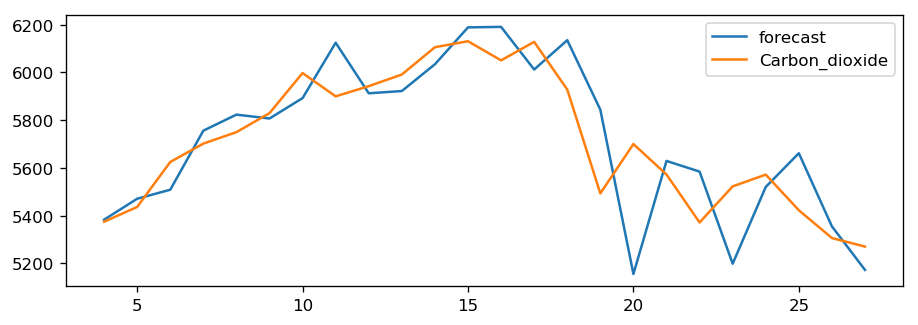

In [44]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.value[:85]
test = df.value[85:]

In [ ]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# Build Model
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

#> {'mape': 0.02250131357314834,
#>  'me': 3.230783108990054,
#>  'mae': 4.548322194530069,
#>  'mpe': 0.016421001932706705,
#>  'rmse': 6.373238534601827,
#>  'acf1': 0.5105506325288692,
#>  'corr': 0.9674576513924394,
#>  'minmax': 0.02163154777672227}

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

In [ ]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [ ]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

In [ ]:
# Import
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

In [ ]:
# !pip3 install pyramid-arima
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()